# Getting started

In [1]:
import pymultieis as pym
import numpy as np
import torch

In [2]:
# Load the file containing the frequencies
F = torch.as_tensor(np.load('../../../data/redox_exp_50/freq_50.npy'))
# Load the file containing the admittances (a set of 50 spectra)
Y = torch.as_tensor(np.load('../../../data/redox_exp_50/Y_50.npy'))
# Load the file containing the standard deviation of the admittances
Yerr = torch.as_tensor(np.load('../../../data/redox_exp_50/sigma_Y_50.npy'))


In [3]:
print(F.shape)
print(Y.shape)
print(Yerr.shape)

torch.Size([45])
torch.Size([45, 50])
torch.Size([45, 50])


In [4]:
def par(a, b):
    """
    Defines the total impedance of two circuit elements in parallel
    """
    return 1/(1/a + 1/b)

def redox(p, f):
    w = 2*torch.pi*f                        # Angular frequency
    s = 1j*w                                # Complex variable
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rct = p[3]
    Wct = p[4]
    Rw = p[5]
    Zw = Wct/torch.sqrt(w) * (1-1j)         # Planar infinite length Warburg impedance
    Zdl = 1/(s**nh*Qh)                      # admittance of a CPE
    Z = Rs + par(Zdl, Rct + par(Zw, Rw))
    Y = 1/Z
    return torch.cat((Y.real, Y.imag), dim = 0)


In [5]:
# def redox(p, f):
#     w = 2*torch.pi*f               # Angular frequency
#     s = 1j*w                       # Complex variable
#     Rs = p[0]
#     Qh = p[1]
#     nh = p[2]
#     Rct = p[3]
#     Wct = p[4]
#     Rw = p[5]
#     Zw = Wct/torch.sqrt(w) * (1-1j) # Planar infinite length Warburg impedance
#     Ydl = (s**nh)*Qh                # admittance of a CPE
#     Z1 = (1/Zw + 1/Rw)**-1
#     Z2 = (Rct+Z1)
#     Y2 = Z2**-1
#     Y3 = (Ydl + Y2)
#     Z3 = 1/Y3
#     Z = Rs + Z3
#     Y = 1/Z
#     return torch.cat((Y.real, Y.imag), dim = 0)


In [5]:
p0 = torch.as_tensor([1.6295e+02, 3.0678e-08, 9.3104e-01, 1.1865e+04, 4.7125e+05, 1.3296e+06])

bounds = [[1e-15,1e15], [1e-9, 1e2], [1e-1,1e0], [1e-15,1e15], [1e-15,1e15], [1e-15,1e15]]

smf_sigma = torch.as_tensor([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.]) # Smoothing factor used with the standard deviation

smf_modulus = torch.as_tensor([1., 1., 1., 1., 1., 1.]) # Smoothing factor used with the modulus

labels = {"Rs":"$\Omega$", "Qh":"$F^{nh}$", "nh":"-", "Rct":"$\Omega$", "Wct":"$\Omega\cdot s^{-0.5}$", "Rw":"$\Omega$"}



## 1. using the standard deviation as weighting

In [7]:
eis_redox_sigma = pym.Multieis(p0, F, Y, bounds, smf_sigma, redox, weight= Yerr, immittance='admittance')


Using initial
Iteration : 0, Loss : 4.69123e+04
Iteration : 599, Loss : 2.98002e+01
Optimization complete
total time is 0:01:04.534157
 

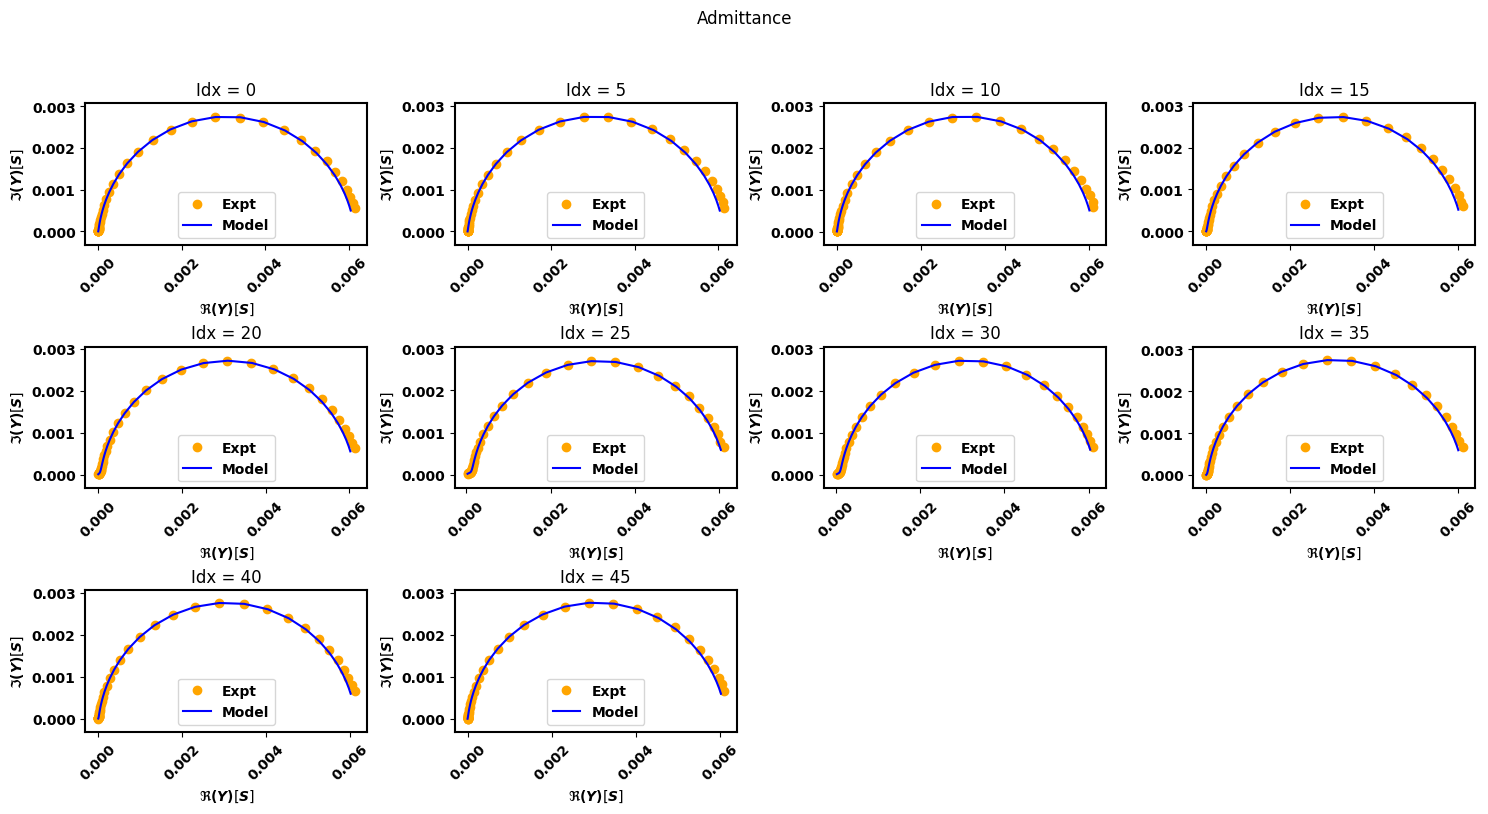

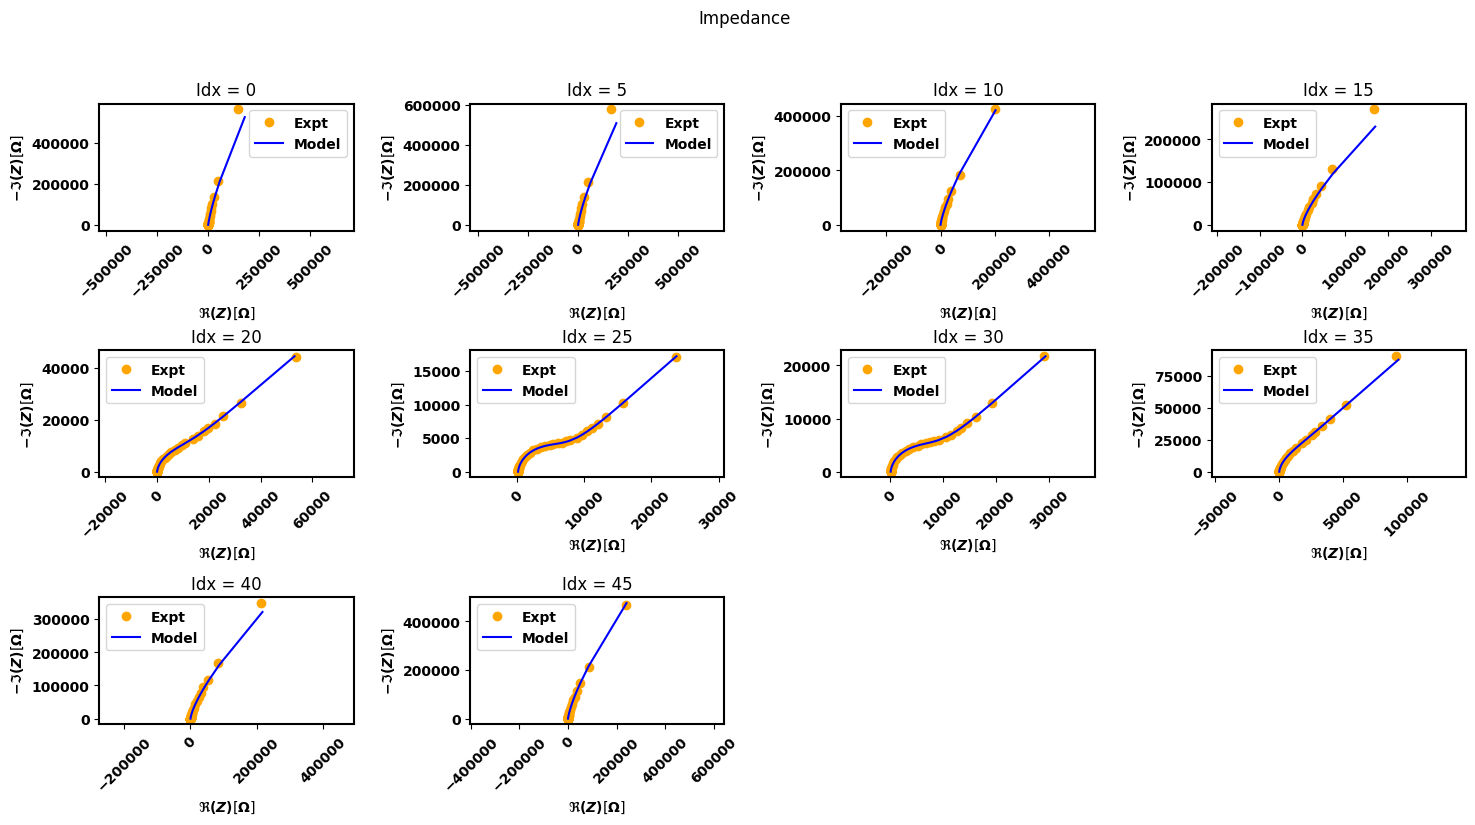

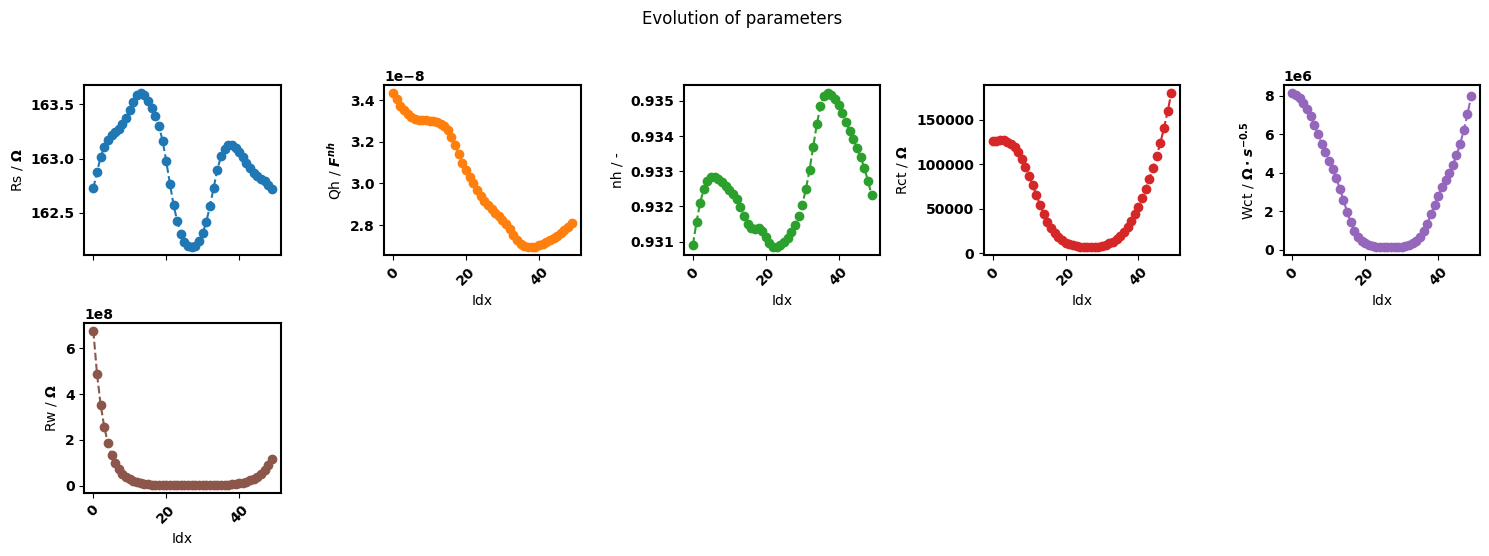

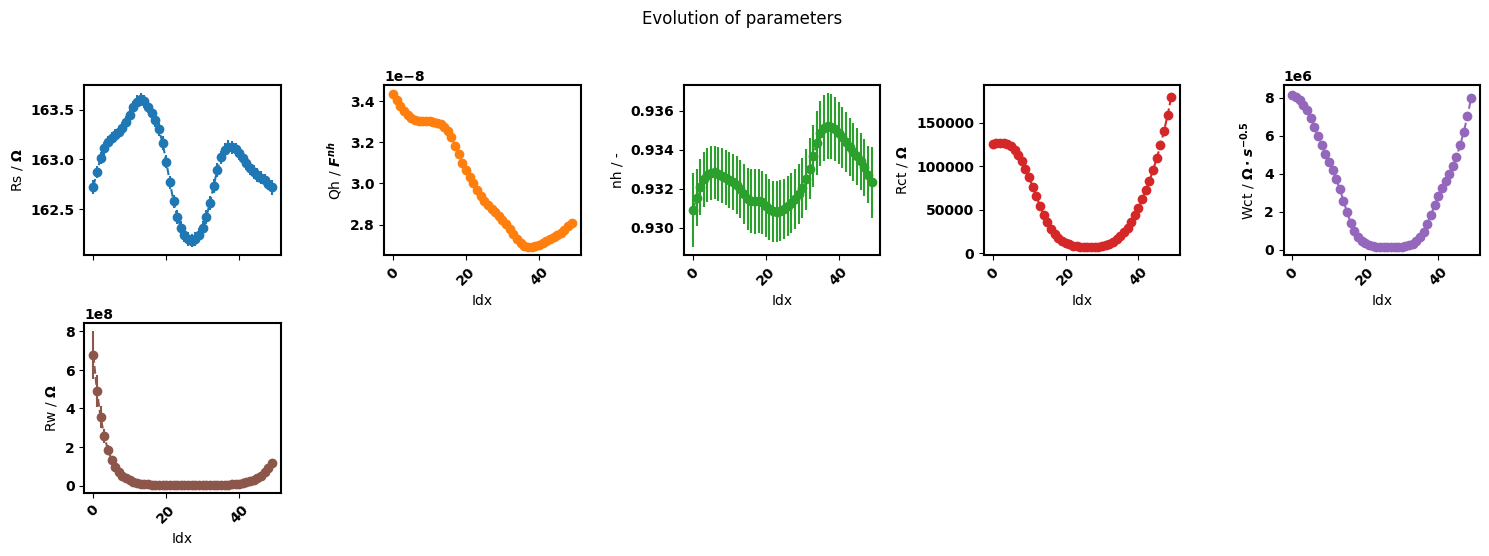

In [8]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous(method = 'bfgs')
eis_redox_sigma.plot_nyquist(5)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)


Using prefit
Iteration : 507, Loss : 2.42203e+01
Optimization complete
total time is 0:00:19.243477 

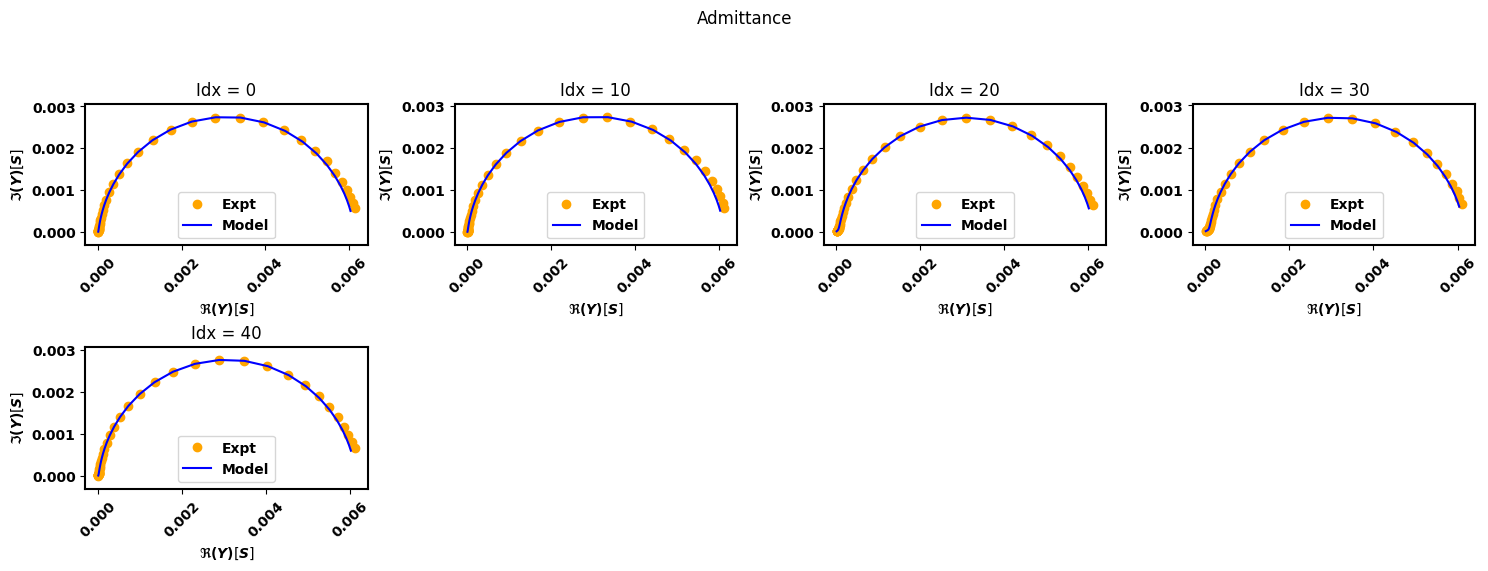

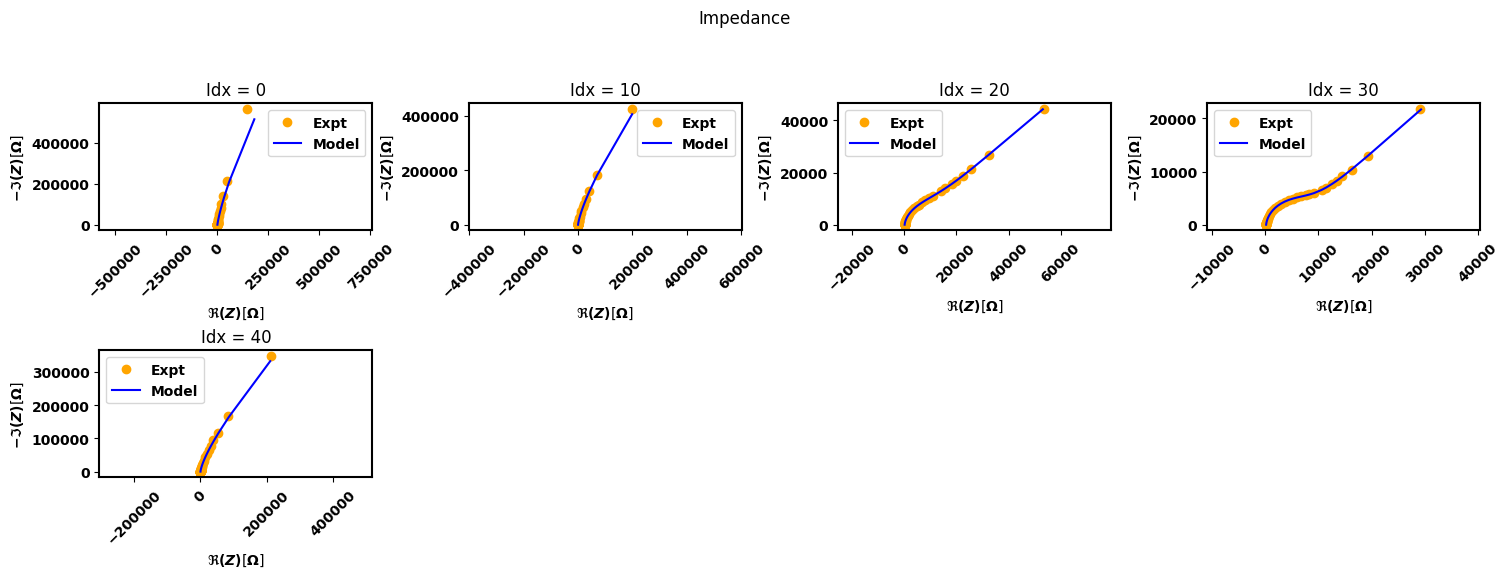

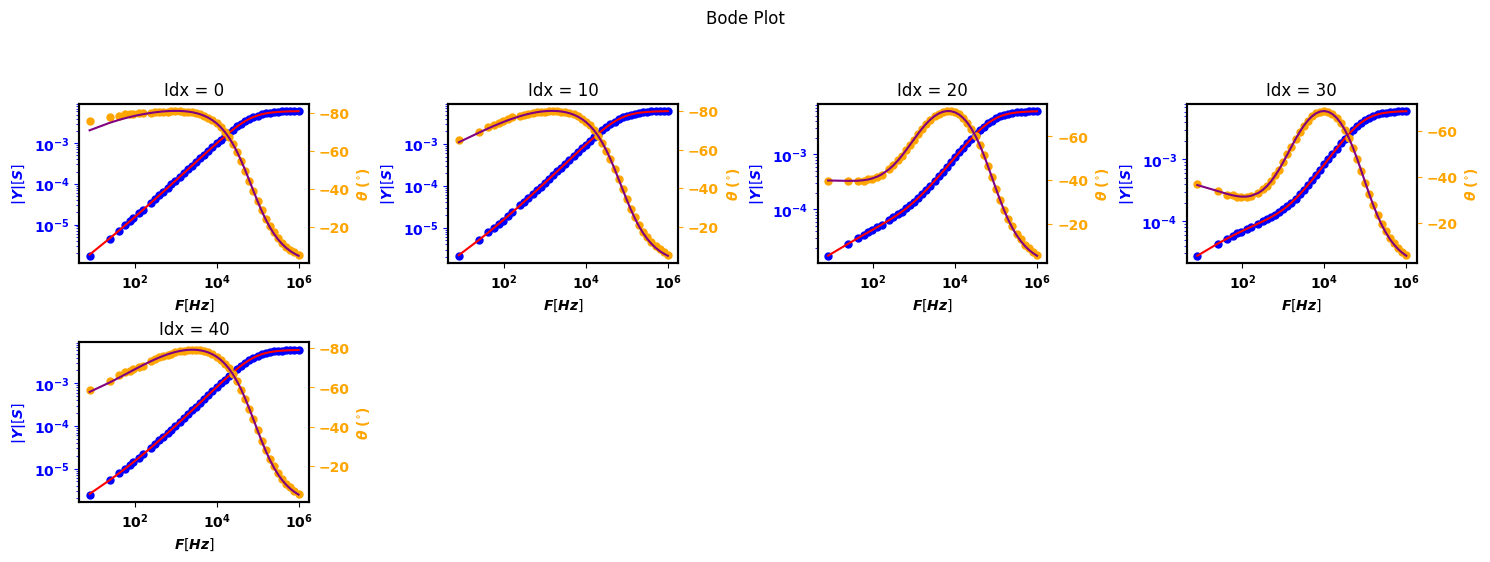

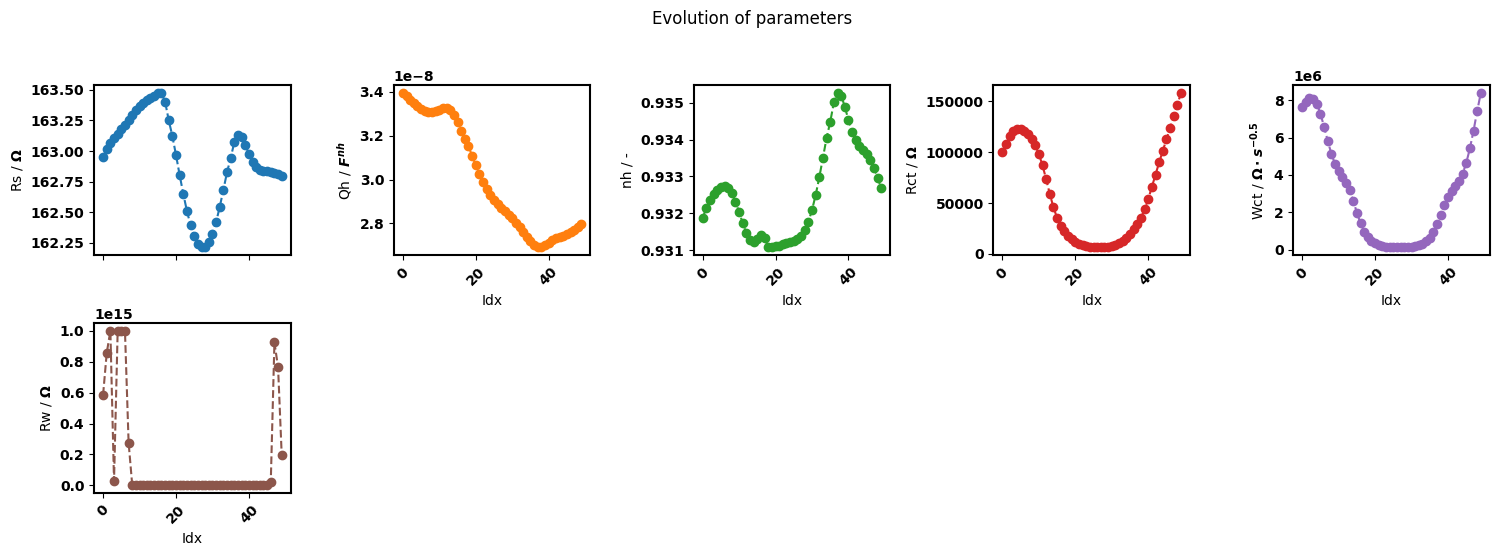

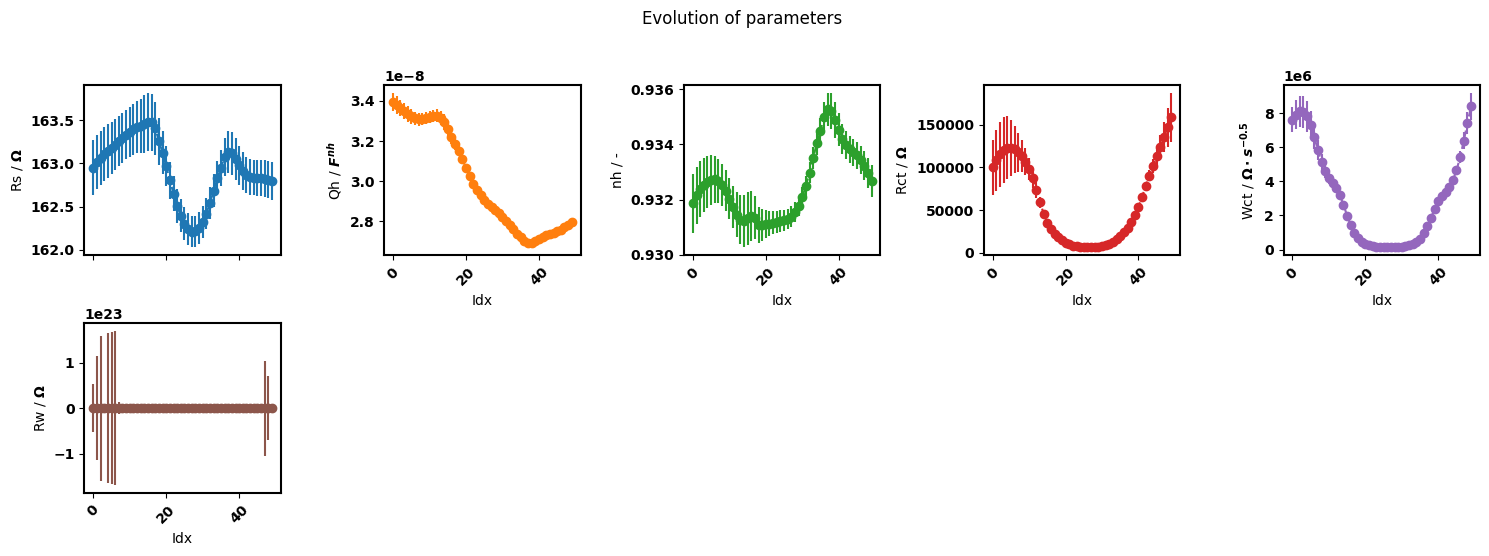

In [9]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous_zero()
eis_redox_sigma.plot_nyquist(10)
eis_redox_sigma.plot_bode(steps = 10)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)

## 2. Using the modulus as weighting

There are many cases where we do not have the data for the standard deviation of the admittance or impedance. ``pymultieis`` offers other weighting options. 
In this second example we shall fit using the modulus as the weighting. All you need do is set the weight parameter to the string "modulus".


Using initial
Iteration : 0, Loss : 4.11945e-01
Iteration : 767, Loss : 3.74253e-05
Optimization complete
total time is 0:00:45.652602
 

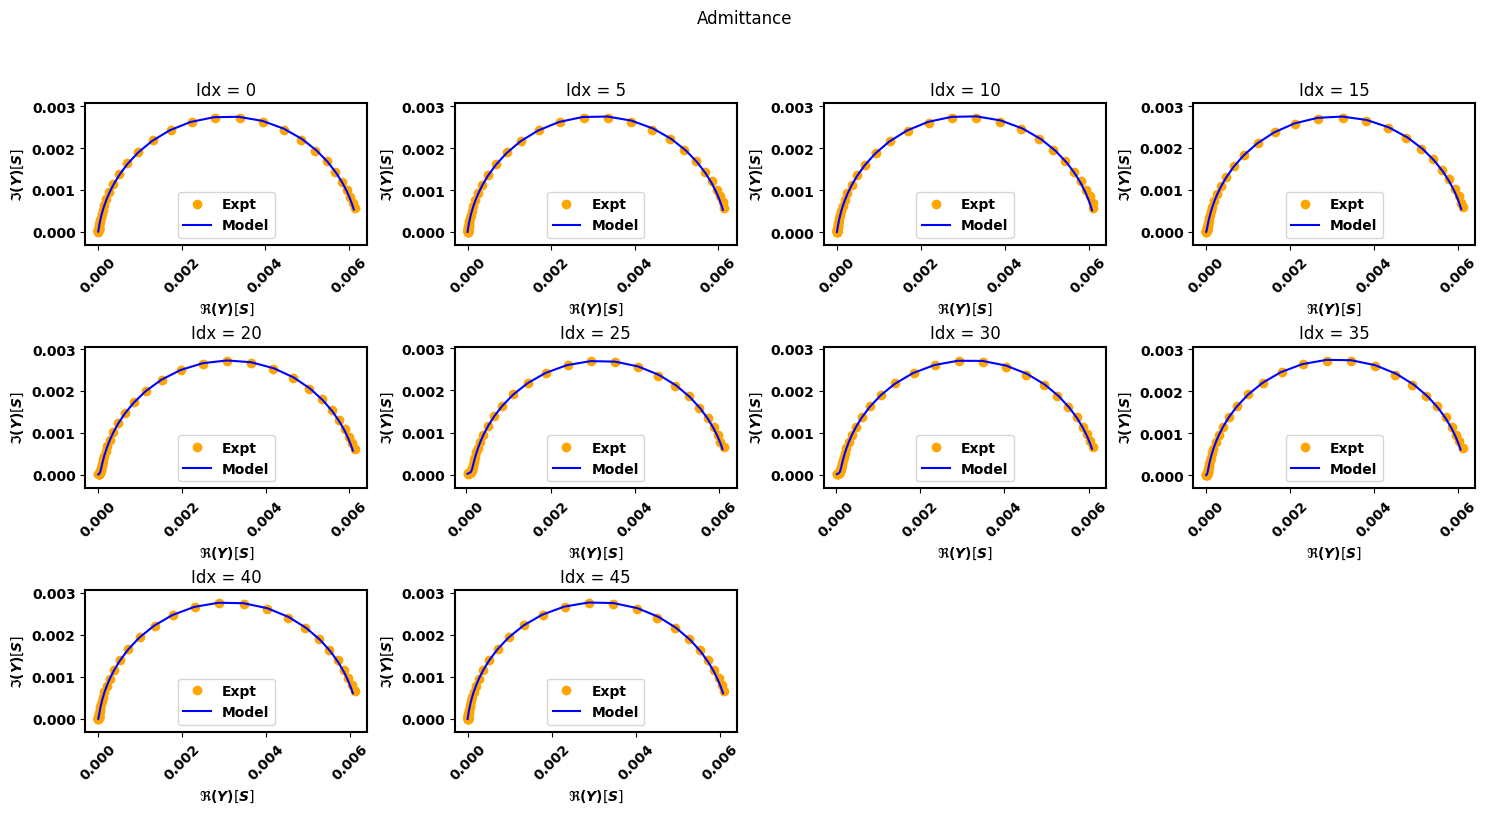

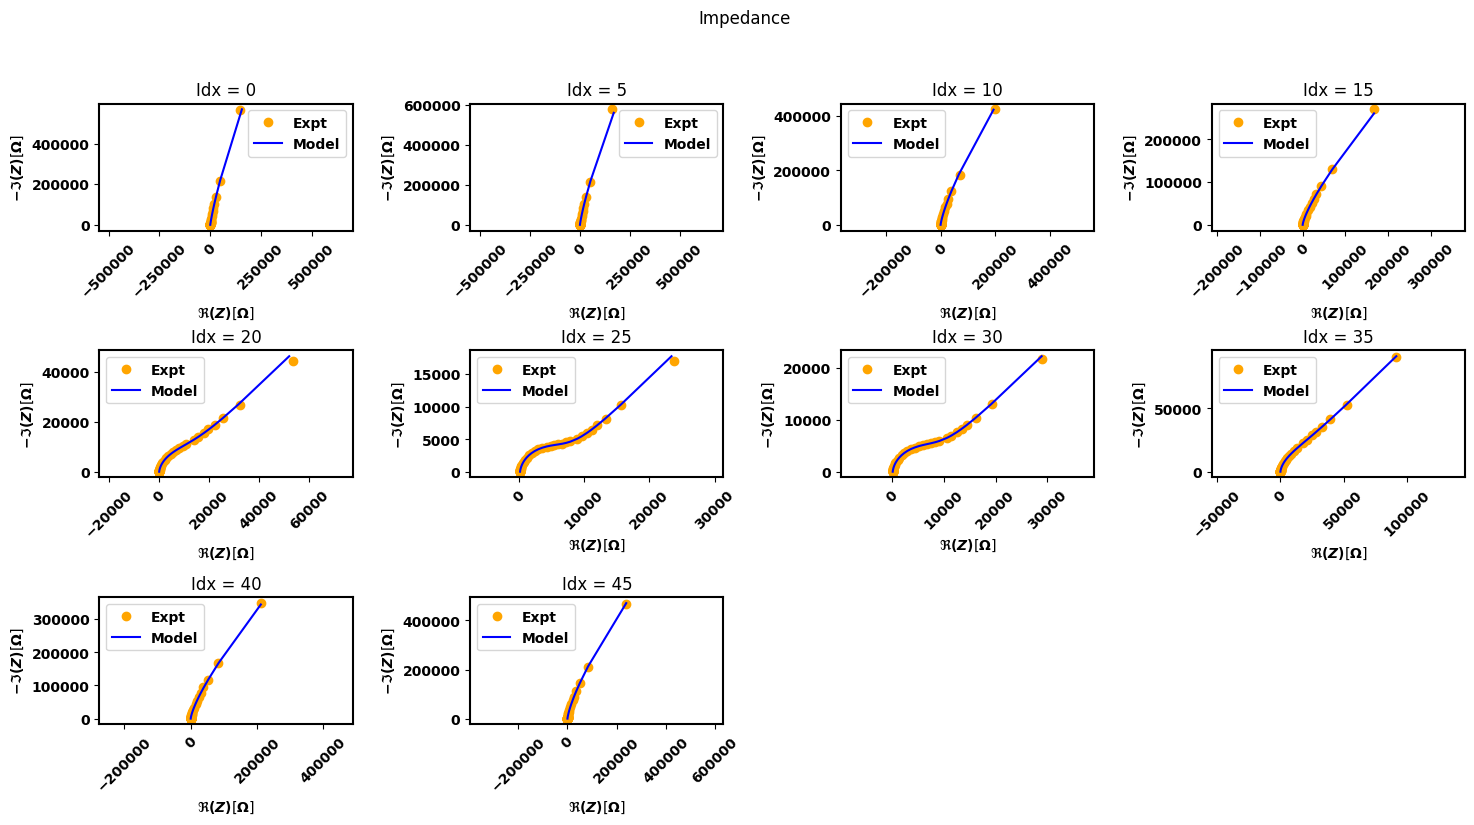

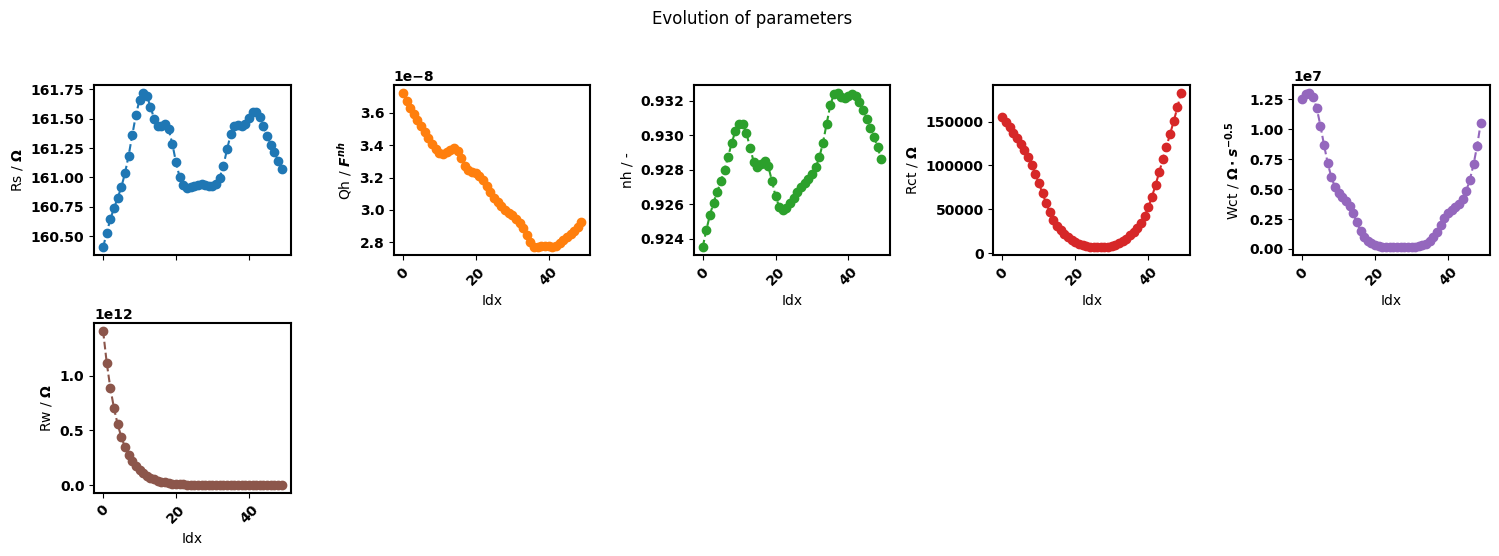

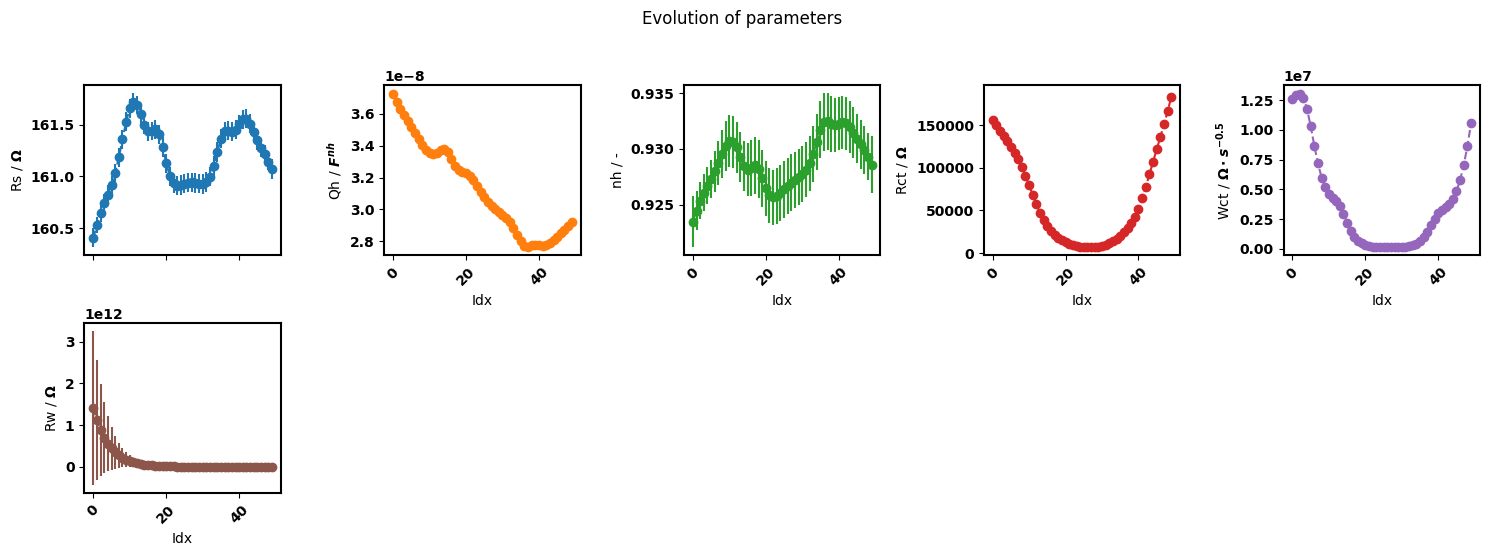

In [6]:
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'bfgs')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(labels=labels)
eis_redox_modulus.plot_params(True, labels=labels)

### Make a least squares fit directly after running `fit_simultaneous()`
Here fit_sequential() uses the optimal parameters produced from fit_simultaneous() as initial guesses.

In [11]:
# Reinstantiate class
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'bfgs')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_sequential(indices=None)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)


Using initial
Iteration : 0, Loss : 4.11945e-01
Iteration : 767, Loss : 3.74253e-05

## 3. Fitting with the stochastic option


Using initial
0: loss=4.119e-01
10000: loss=4.565e-05
20000: loss=3.768e-05
30000: loss=3.754e-05
40000: loss=3.749e-05
50000: loss=3.748e-05
60000: loss=3.747e-05
70000: loss=3.747e-05
80000: loss=3.746e-05
90000: loss=3.746e-05
Optimization complete
total time is 0:05:50.534917 

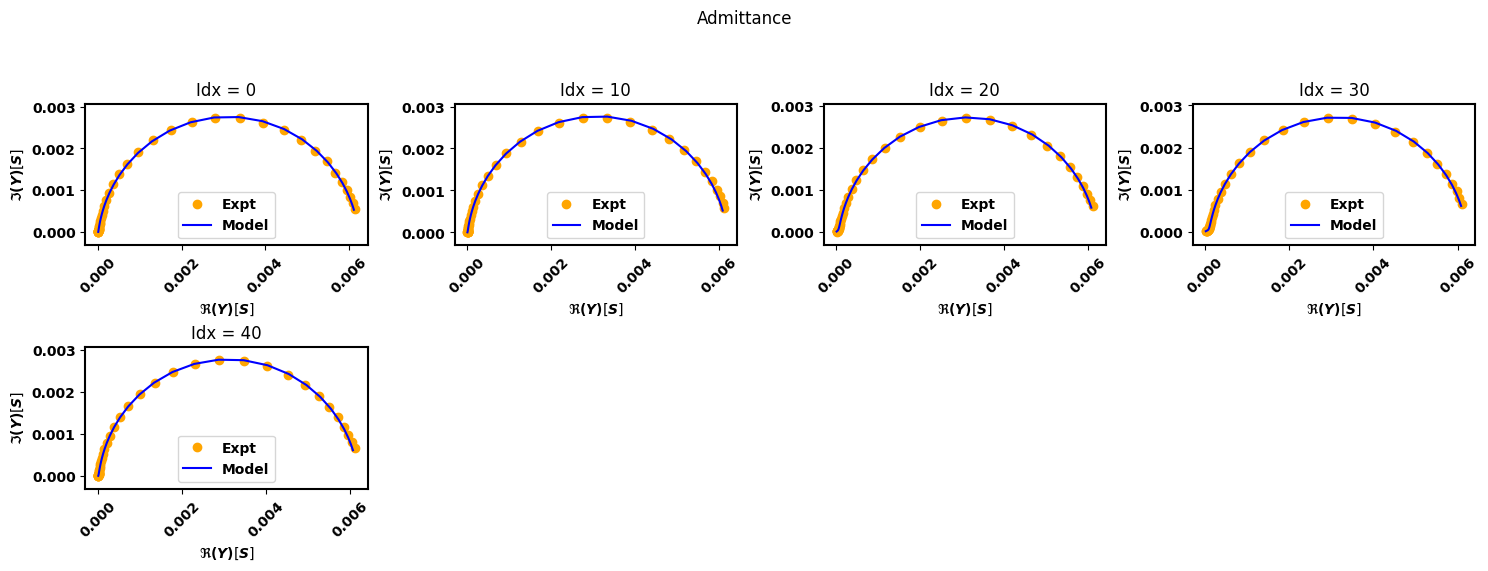

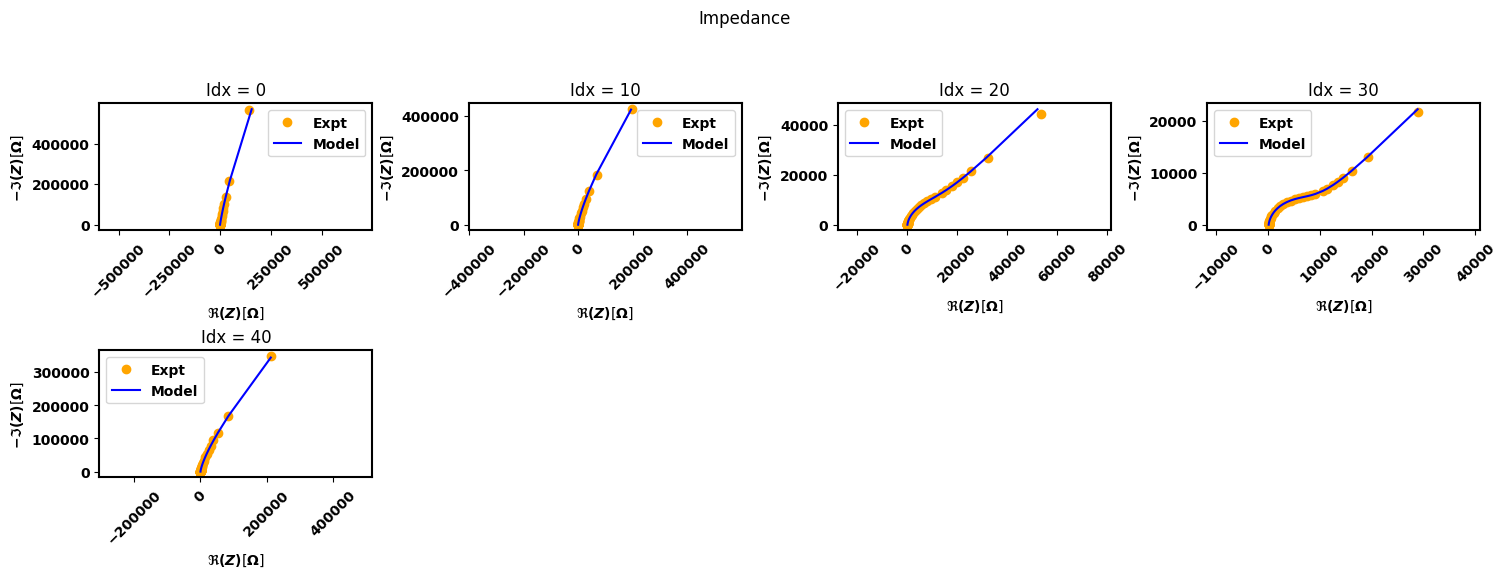

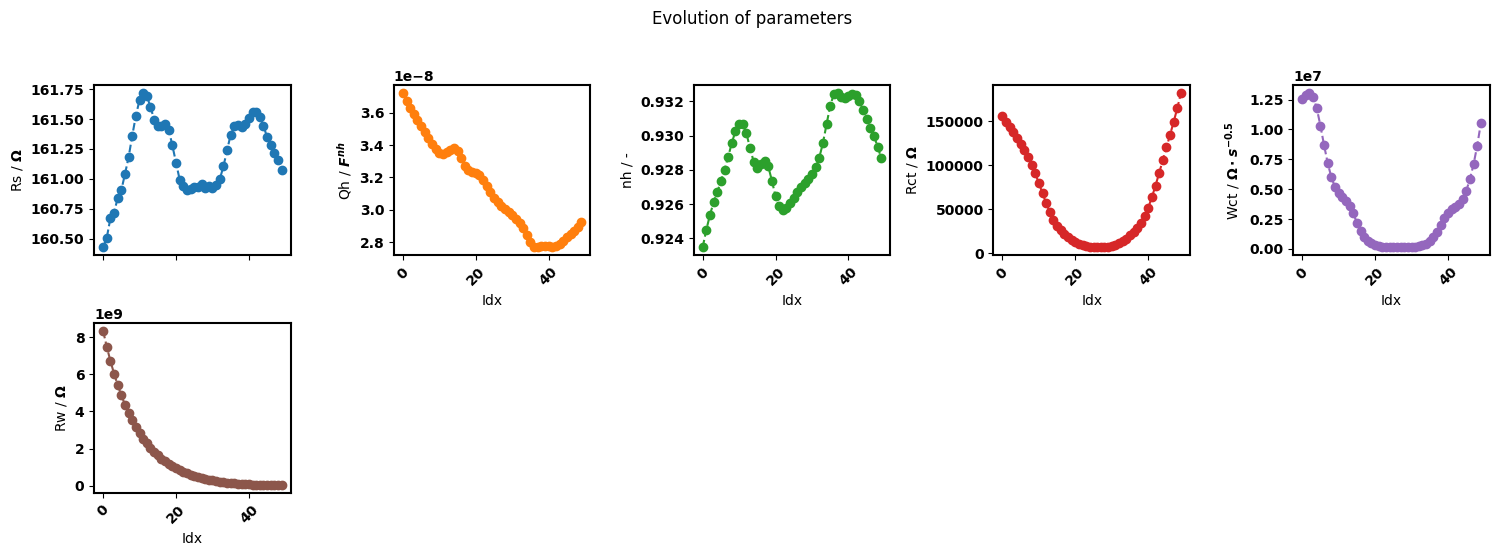

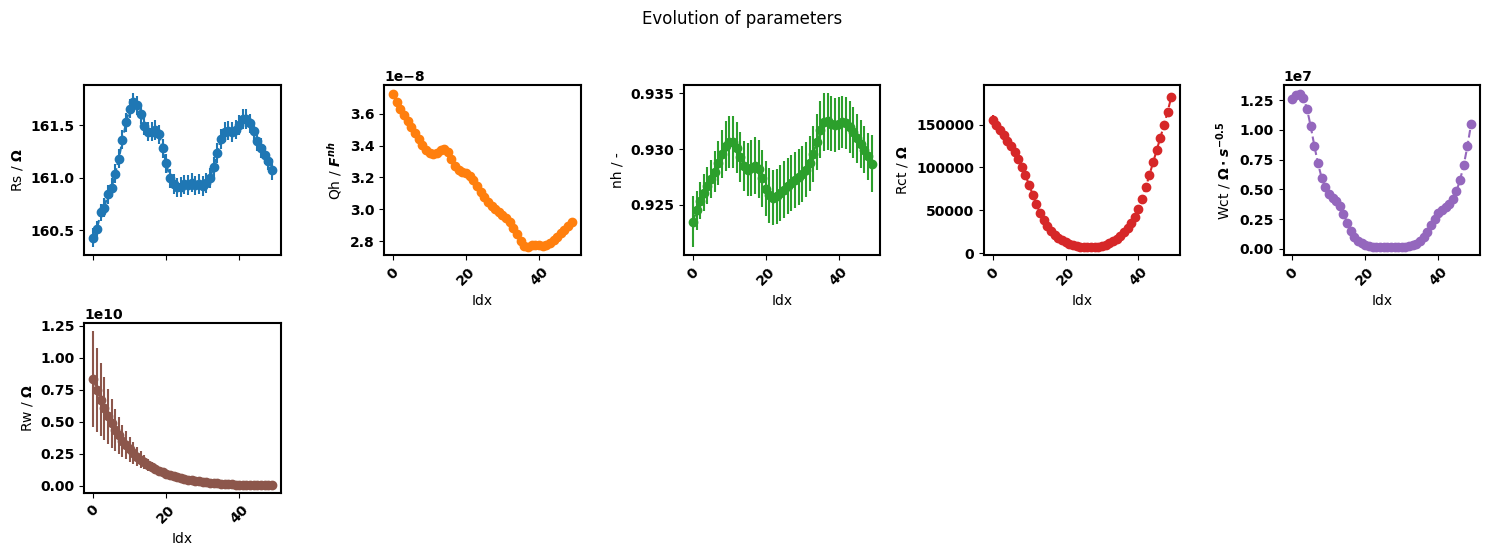

In [ ]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_stochastic()
eis_redox_modulus.plot_nyquist(10)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## 4. Running the Bootstrap MonteCarlo option


Using initial
Iteration : 0, Loss : 4.11945e-01
Iteration : 767, Loss : 3.74253e-05
Optimization complete
total time is 0:00:28.868639
 
Please run fit_simultaneous() or fit_stochastic()
              on your data before running the compute_perr_mc() method.
              ignore this message if you did.

Using prefit

Optimization complete
total time is 0:14:20.921227 

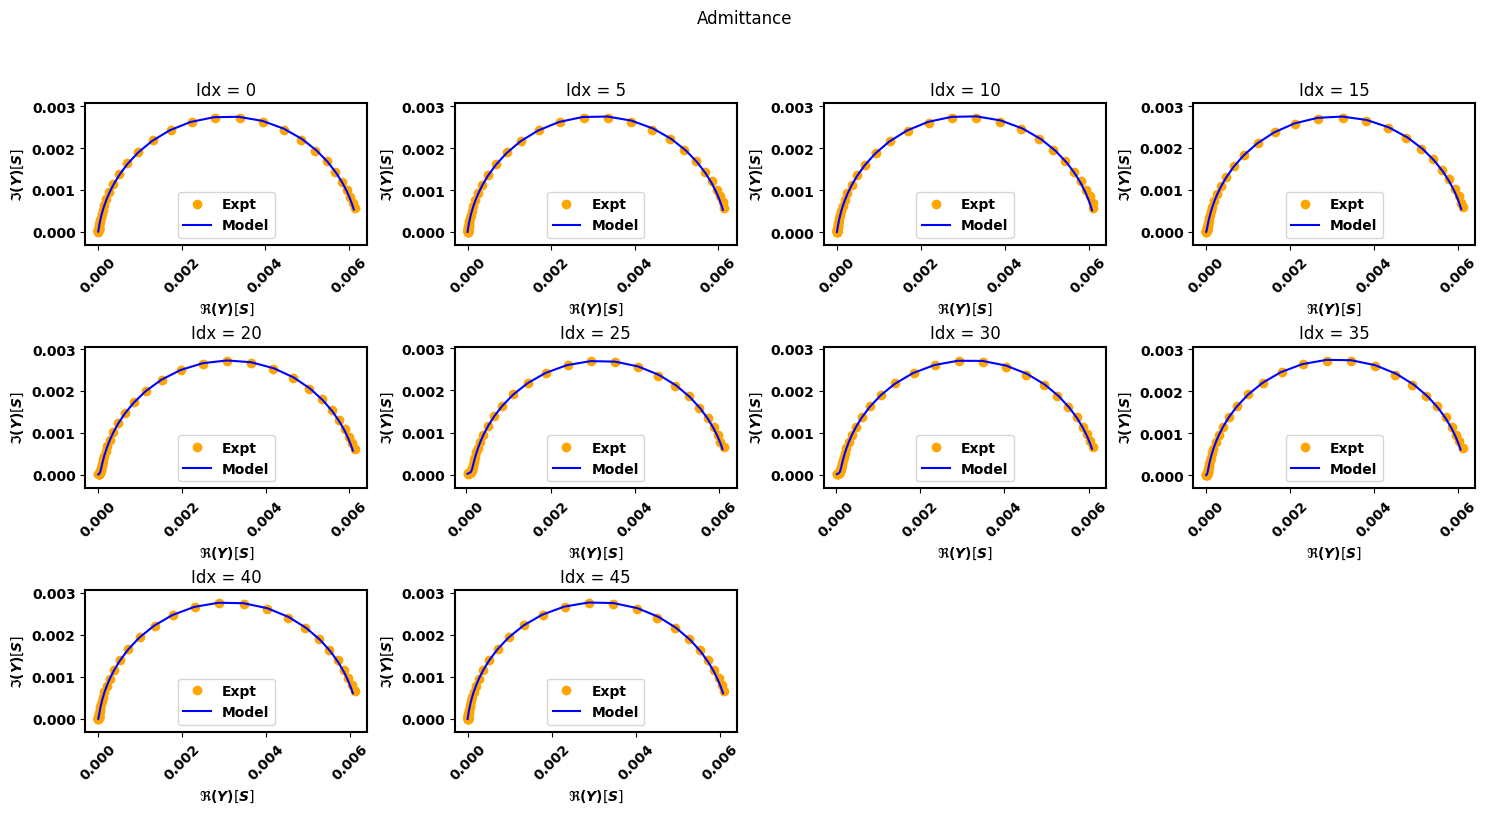

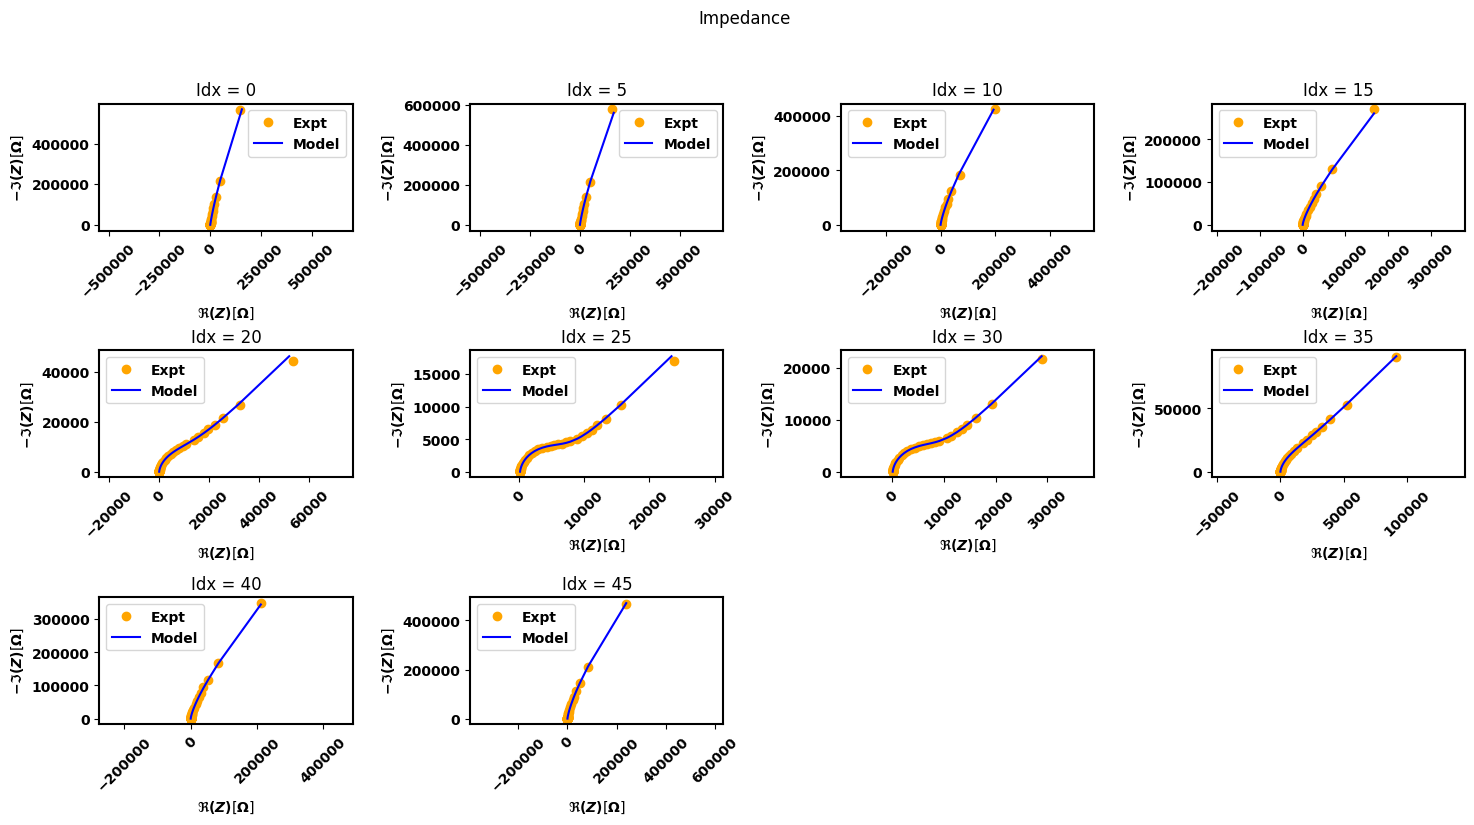

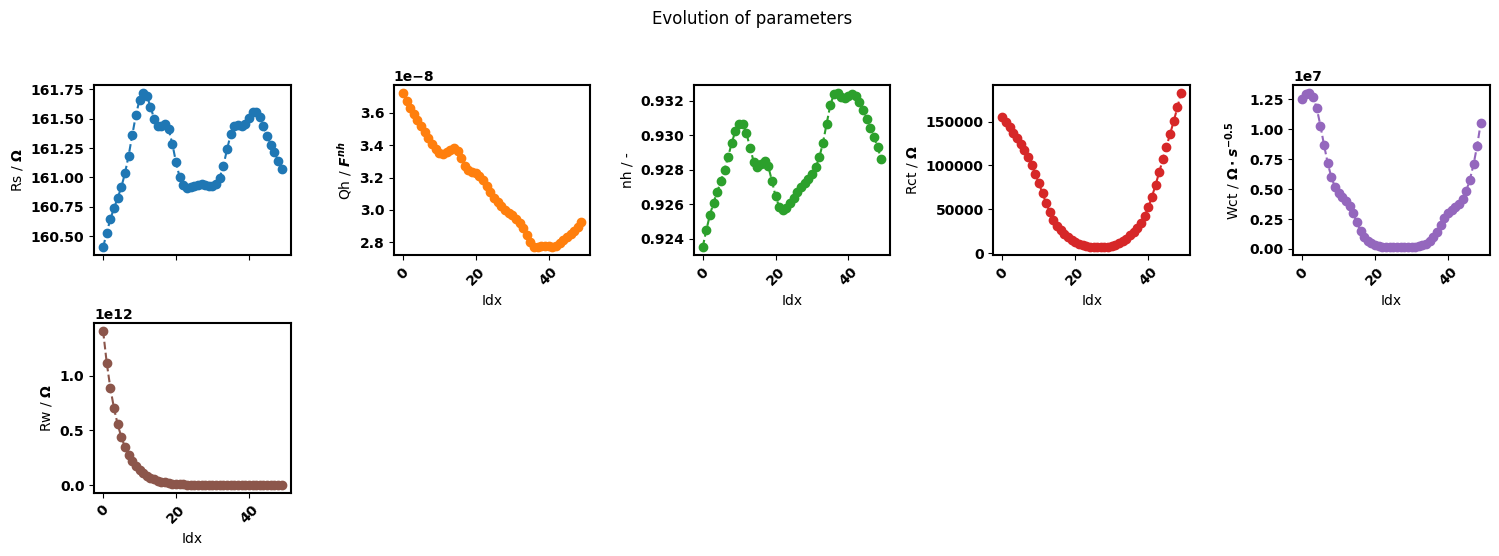

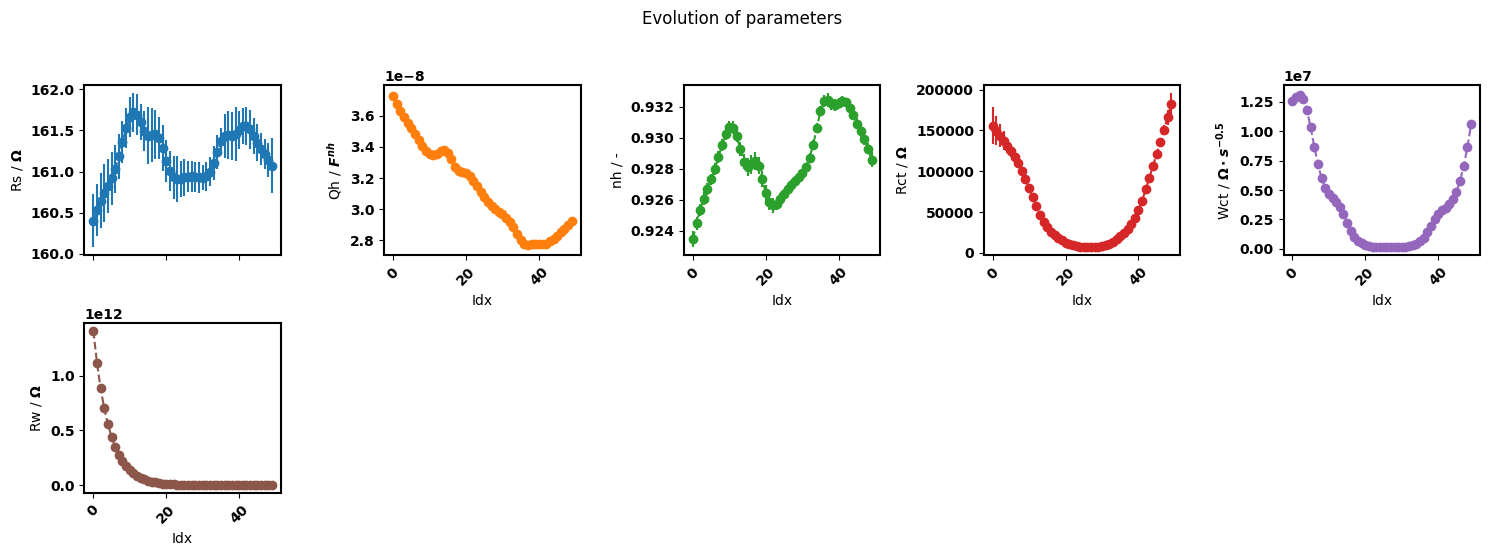

In [ ]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'bfgs')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.compute_perr_mc(n_boots=500)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## 5. Keeping a parameter constant


Using initial
Iteration : 0, Loss : 4.11945e-01
Iteration : 667, Loss : 3.78235e-05
Optimization complete
total time is 0:00:27.158423
 

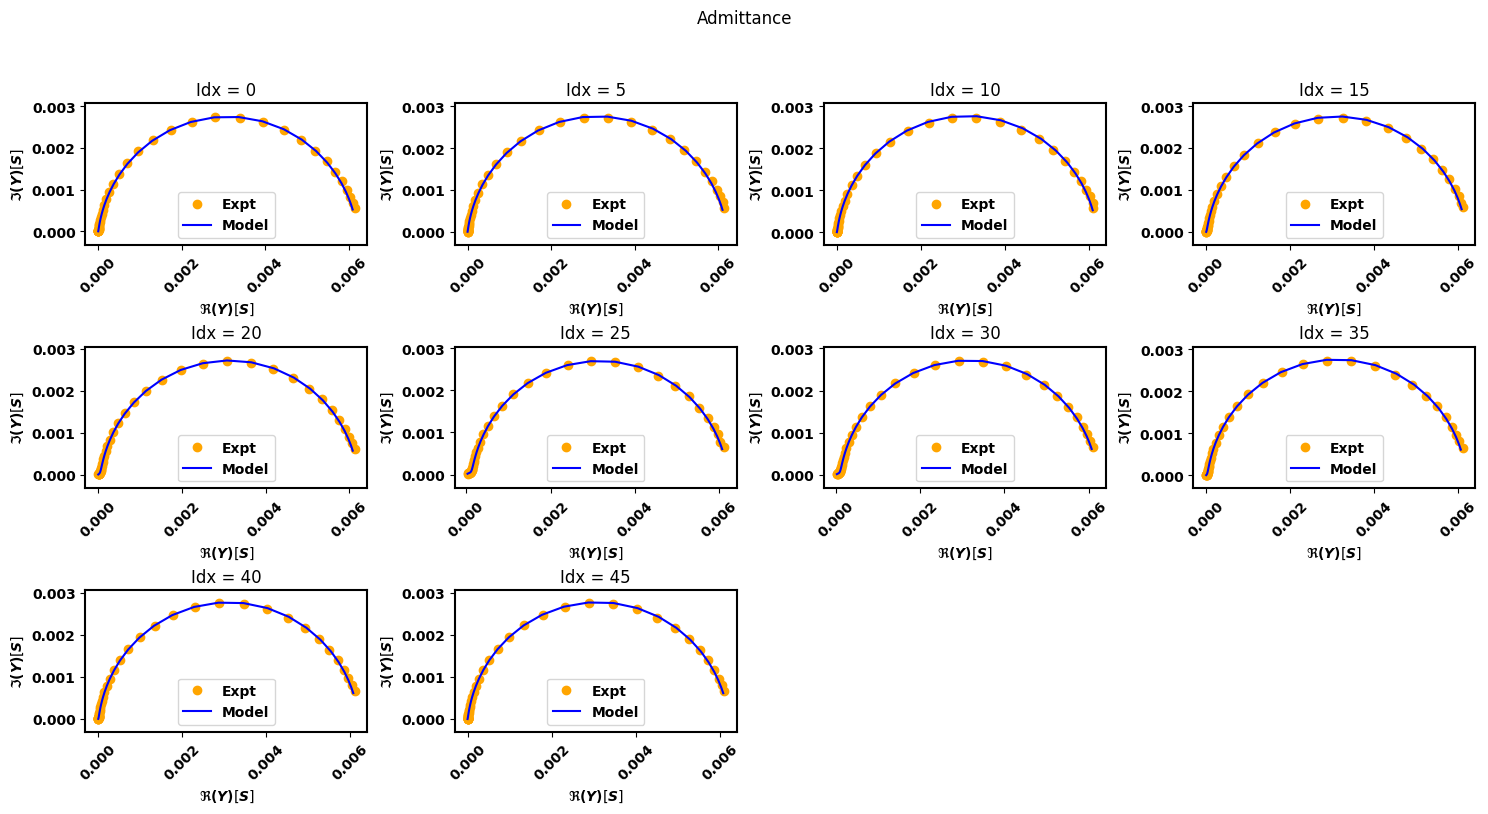

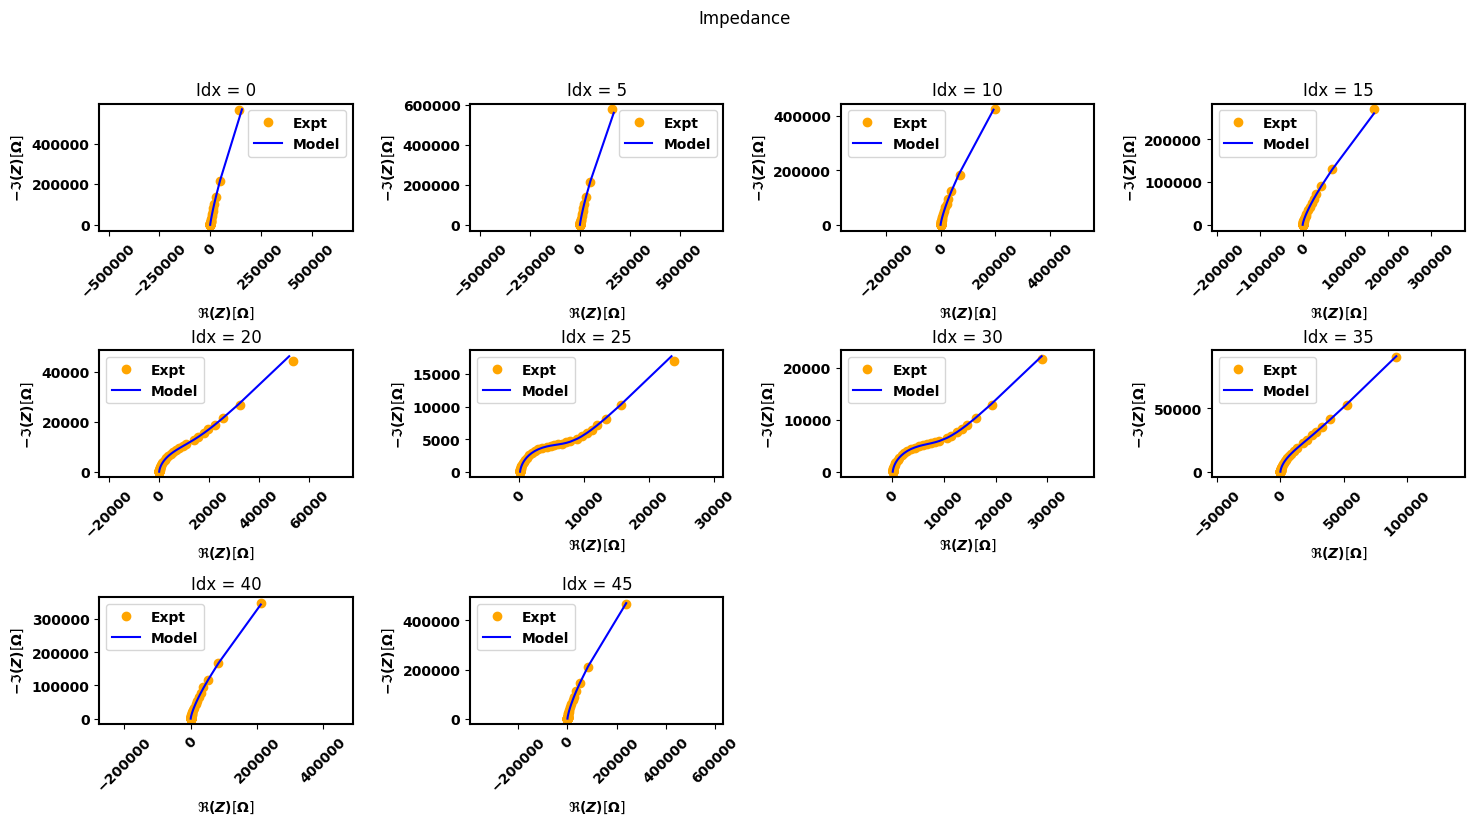

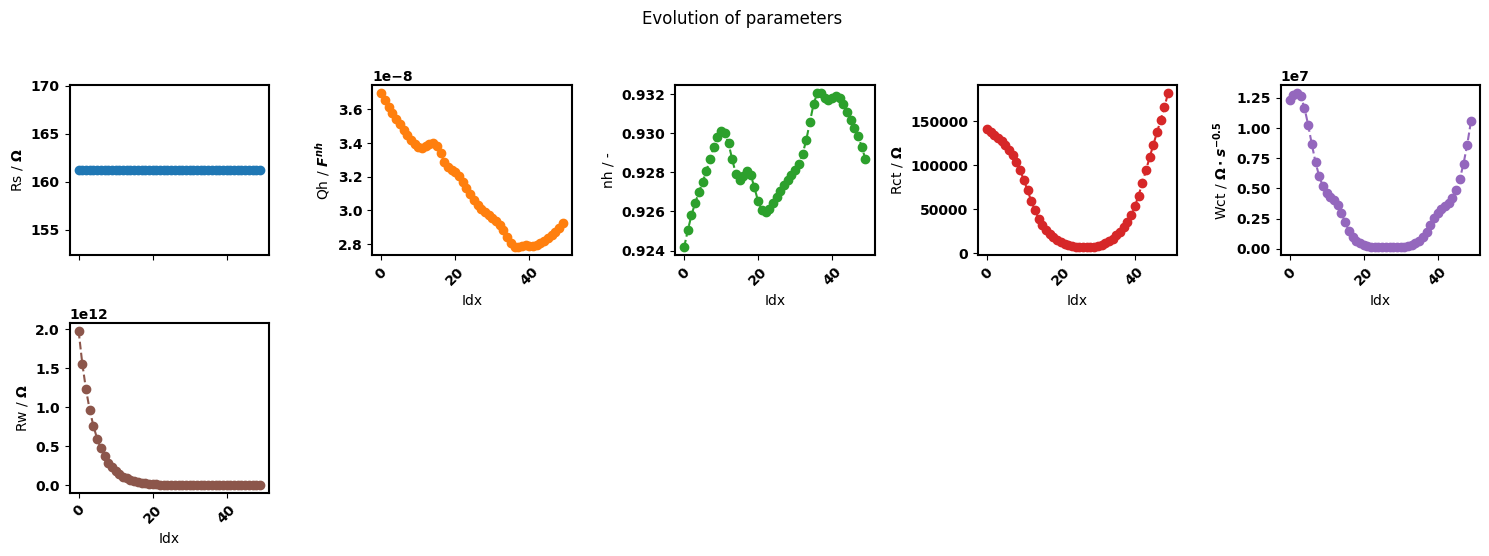

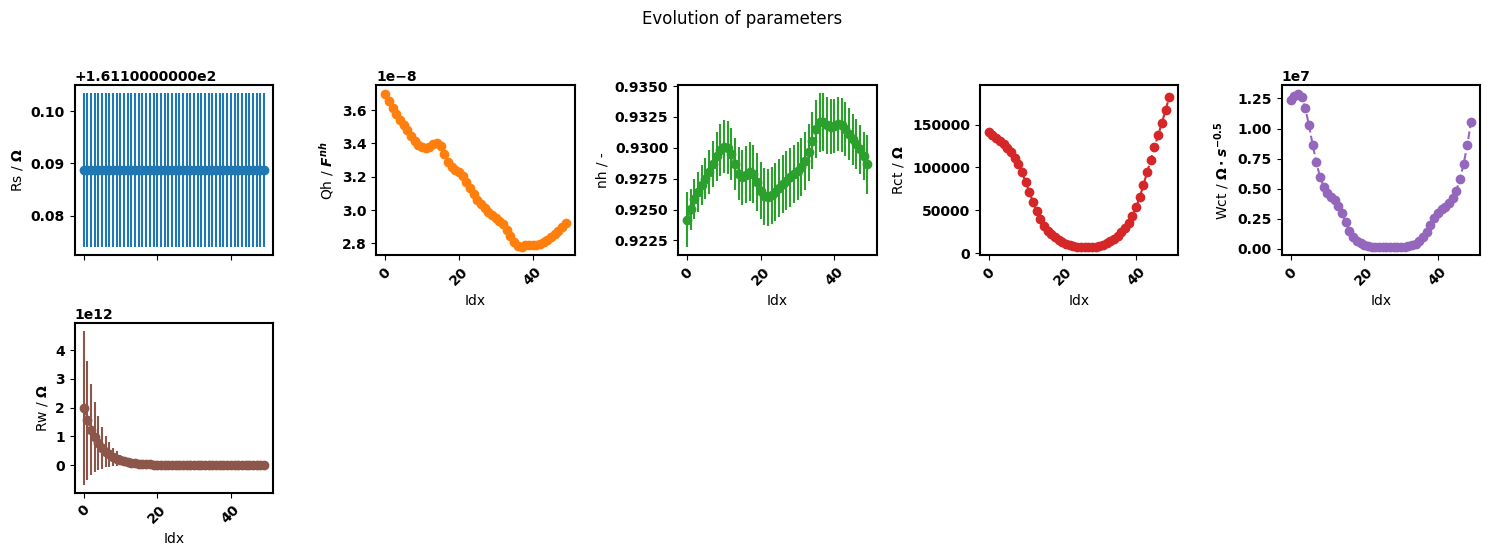

In [ ]:
# Reinstantiate class and fit keeping a parameter constant
smf_const = smf_modulus.clone()
smf_const[0] = torch.inf # here we keep the first parameter constant
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_const, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'bfgs')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## 6. Saving the plots

In [ ]:
eis_redox_modulus.save_plot_nyquist(steps=10, fname='example_results')
eis_redox_modulus.save_plot_bode(steps=10, fname='example_results')
eis_redox_modulus.save_plot_params(False, fname='example_results')

## 7. saving the results

In [ ]:
eis_redox_modulus.save_results(fname='example_results')